<a href="https://colab.research.google.com/github/vssood/WU_DL/blob/master/Assignments/WU_DL_AS_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Module 7 Assignment: Computer Vision Neural Network**

**Student Name: Your Name**

# Google CoLab Instructions

If you are using Google CoLab, it will be necessary to mount your GDrive so that you can send your notebook during the submit process. Running the following code will map your GDrive to ```/content/drive```.

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Mounted at /content/drive
Note: using Google CoLab


# Assignment Submit Function

You will submit the 10 programming assignments electronically.  The following submit function can be used to do this.  My server will perform a basic check of each assignment and let you know if it sees any basic problems. 

**It is unlikely that should need to modify this function.**

In [ ]:
import base64
import os
import numpy as np
import pandas as pd
import requests
import PIL
import PIL.Image
import io

# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - List of pandas dataframes or images.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    payload = []
    for item in data:
        if type(item) is PIL.Image.Image:
            buffered = BytesIO()
            item.save(buffered, format="PNG")
            payload.append({'PNG':base64.b64encode(buffered.getvalue()).decode('ascii')})
        elif type(item) is pd.core.frame.DataFrame:
            payload.append({'CSV':base64.b64encode(item.to_csv(index=False).encode('ascii')).decode("ascii")})
    r= requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={ 'payload': payload,'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code==200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Assignment Instructions

For this assignment, you will use YOLO running on Google CoLab.  I suggest that you run this assignment on CoLab because the example code below is already setup to get you started with the correct versions of  YOLO on TensorFlow 2.0.

For this assignment you are provided with 10 image files that contain 10 different webcam pictures taken at the [Venice Sidewalk Cafe](https://www.westland.net/beachcam/) a WebCam that has been in opration since 1996.  You can find the 10 images here:

* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk1.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk2.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk3.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk4.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk5.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk6.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk7.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk8.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk9.png
* https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk10.png

You can see a sample of the WebCam here:

![alt text](https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk1.png)

YOLO does quite well-recognizing objects in this webcam, as the following image illustrates.

![alt text](https://data.heatonresearch.com/data/t81-558/sidewalk/predictions.jpg)

You are to write a script that counts the number of certain objects in each of the images.  Specifically, you are looking for:

* person
* car
* bicycle
* motorbike
* umbrella
* handbag

It is essential that your use YOLO with a threshold of 10% if you want your results to match mine. The sample code below already contains this setting.  Your program can set this threshold with the following command.

* FLAGS.yolo_score_threshold = 0.1

Your submitted data frame should also contain a column that identifies which image generated each row.  This column should be named **image** and contain integer numbers between 1 and 10.  There should be 10 rows in total.  The complete data frame should look something like this (not necessarily exactly these numbers).

|image|person|car|bicycle|motorbike|umbrella|handbag|
|-|-|-|-|-|-|-|
|1|23|0|3|4|0|0|
|2|27|1|8|2|0|0|
|3|29|0|0|0|3|0|
|...|...|...|...|...|...|...|


The following code sets up YOLO and then dumps the classification information for the first image.  This notebook only serves to get you started.  Read in all ten images and generate a data frame that looks like the following. Use the **submit** function as you did in previous assignments.

### Installing YoloV3-TF2

The following code is taken from the module, it installs YoLoV3-TF2 if not already installed.

In [6]:
import sys

!{sys.executable} -m pip install git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-203e76v7
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-203e76v7
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-cp36-none-any.whl size=8851 sha256=6d6aef4eb5600deac28fd21f42cae646fc2d751039837d0c01b8836c6c04ea7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-88t27_ec/wheels/59/1b/97/905ab51e9c0330efe8c3c518aff17de4ee91100412cd6dd553
Successfully built yolov3-tf2


The following code is taken from the module, it downloads needed files for YoLoV3-TF2.

In [9]:
import tensorflow as tf
import os

if COLAB:
  ROOT = '/content/drive/My Drive/ds_projects'
else:
  ROOT = os.path.join(os.getcwd(),'data')

filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/convert.py')

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/data/coco.names')
filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

8192/1277 [================================================================================================================================================================================================] - 0s 0us/step


### Transfering Weights

The following code is taken from the module, it transfers preloaded weights into YOLO.

In [10]:
import sys
!{sys.executable} "{filename_convert_script}" --weights "{filename_darknet_weights}" --output "{filename_converted_weights}"

2020-10-06 13:06:48.336067: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-06 13:06:50.363707: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-06 13:06:50.455723: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-06 13:06:50.455812: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a11b624611bb): /proc/driver/nvidia/version does not exist
2020-10-06 13:06:50.545710: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-10-06 13:06:50.546057: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1884bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-06 13:06:50.546094: I tensorflow/com

Now that we have all of the files needed for YOLO, we are ready to use it to recognize components of an image.

In [14]:
import os
os.remove(filename_convert_script)

# Starter Code

In [11]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

import matplotlib.pyplot as plt

# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, 'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

# Locate devices to run YOLO on (e.g. GPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
# This assignment does not use the "Tiny version"
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


Modify the code below to create your solution.

In [38]:
images = [
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk1.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk2.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk3.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk4.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk5.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk6.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk7.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk8.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk9.png',
'https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk10.png'
]

In [97]:
import pandas as pd

# i = 1
submit_df = pd.DataFrame()
for i in range( 1,11):

    url = f"https://data.heatonresearch.com/data/t81-558/sidewalk/sidewalk{i}.png"
    response = requests.get(url)
    img_raw = tf.image.decode_image(response.content, channels=3)

    # Preprocess image
    img = tf.expand_dims(img_raw,   0)
    img = transform_images(img, FLAGS.size)

    # Desired threshold (any sub-image below this confidence level will be ignored.)
    FLAGS.yolo_score_threshold = 0.1

    # Recognize and report results
    boxes, scores, classes, nums = yolo(img)

    #submit_df = pd.DataFrame()

    outdict ={'image':0, 'person':0, 'car': 0, 'bicycle' : 0, 'motorbike': 0, 'umbrella': 0, 'handbag': 0}

    outdict['image'] = i
    print('detections:')
    for i in range(nums[0]):
        cls = class_names[int(classes[0][i])]
        score = np.array(scores[0][i])
        box = np.array(boxes[0][i])
        #print(f"\t{cls}, {score}, {box}")
        if cls in outdict:
            outdict[cls] += 1

# populate data frame 
    print(outdict)
    submit_df = submit_df.append(outdict, ignore_index=True   )
    # pd.concat([submit_df([v], columns=[k])   for k, v in outdict.items()],ignore_index=True)

    submit_df.head()
# This is your student key that I emailed to you at the beginnning of the semester.
key = "JNAl4M33jgax0oM1GJFuF6QHnAk58HWT3FElTJwQ"  # This is an example key and will not work.

# You must also identify your source file.  (modify for your local setup)
file='/content/drive/My Drive/Colab Notebooks/assignment_yourname_class7.ipynb'  # Google CoLab
# file='C:\\Users\\jeffh\\projects\\t81_558_deep_learning\\assignments\\assignment_yourname_class7.ipynb'  # Windows
# file='/Users/jheaton/projects/t81_558_deep_learning/assignments/assignment_yourname_class7.ipynb'  # Mac/Linux


#submit(source_file=file,data=[submit_df],key=key,no=7)


detections:
{'image': 1, 'person': 23, 'car': 0, 'bicycle': 3, 'motorbike': 4, 'umbrella': 0, 'handbag': 0}
detections:
{'image': 2, 'person': 27, 'car': 1, 'bicycle': 8, 'motorbike': 2, 'umbrella': 0, 'handbag': 0}
detections:
{'image': 3, 'person': 29, 'car': 0, 'bicycle': 0, 'motorbike': 0, 'umbrella': 3, 'handbag': 0}
detections:
{'image': 4, 'person': 51, 'car': 0, 'bicycle': 6, 'motorbike': 1, 'umbrella': 1, 'handbag': 1}
detections:
{'image': 5, 'person': 49, 'car': 0, 'bicycle': 9, 'motorbike': 0, 'umbrella': 0, 'handbag': 0}
detections:
{'image': 6, 'person': 61, 'car': 0, 'bicycle': 2, 'motorbike': 1, 'umbrella': 1, 'handbag': 0}
detections:
{'image': 7, 'person': 52, 'car': 0, 'bicycle': 0, 'motorbike': 0, 'umbrella': 0, 'handbag': 0}
detections:
{'image': 8, 'person': 56, 'car': 0, 'bicycle': 1, 'motorbike': 0, 'umbrella': 0, 'handbag': 0}
detections:
{'image': 9, 'person': 33, 'car': 1, 'bicycle': 0, 'motorbike': 0, 'umbrella': 1, 'handbag': 0}
detections:
{'image': 10, 'p

In [ ]:
class_names

In [98]:
outdict.items()

dict_items([('image', 10), ('person', 39), ('car', 0), ('bicycle', 1), ('motorbike', 0), ('umbrella', 0), ('handbag', 0)])

In [99]:
submit_df.head(2)

,bicycle,car,handbag,image,motorbike,person,umbrella
0,3.0,0.0,0.0,1.0,4.0,23.0,0.0
1,8.0,1.0,0.0,2.0,2.0,27.0,0.0


In [82]:
submit_df.set_index('image')

,bicycle,car,handbag,motorbike,person,umbrella
image,,,,,,
1.0,3.0,0.0,0.0,4.0,23.0,0.0
2.0,8.0,1.0,0.0,2.0,27.0,0.0
3.0,0.0,0.0,0.0,0.0,29.0,3.0
4.0,6.0,0.0,1.0,1.0,51.0,1.0
5.0,9.0,0.0,0.0,0.0,49.0,0.0
6.0,2.0,0.0,0.0,1.0,61.0,1.0
7.0,0.0,0.0,0.0,0.0,52.0,0.0
8.0,1.0,0.0,0.0,0.0,56.0,0.0
9.0,0.0,1.0,0.0,0.0,33.0,1.0


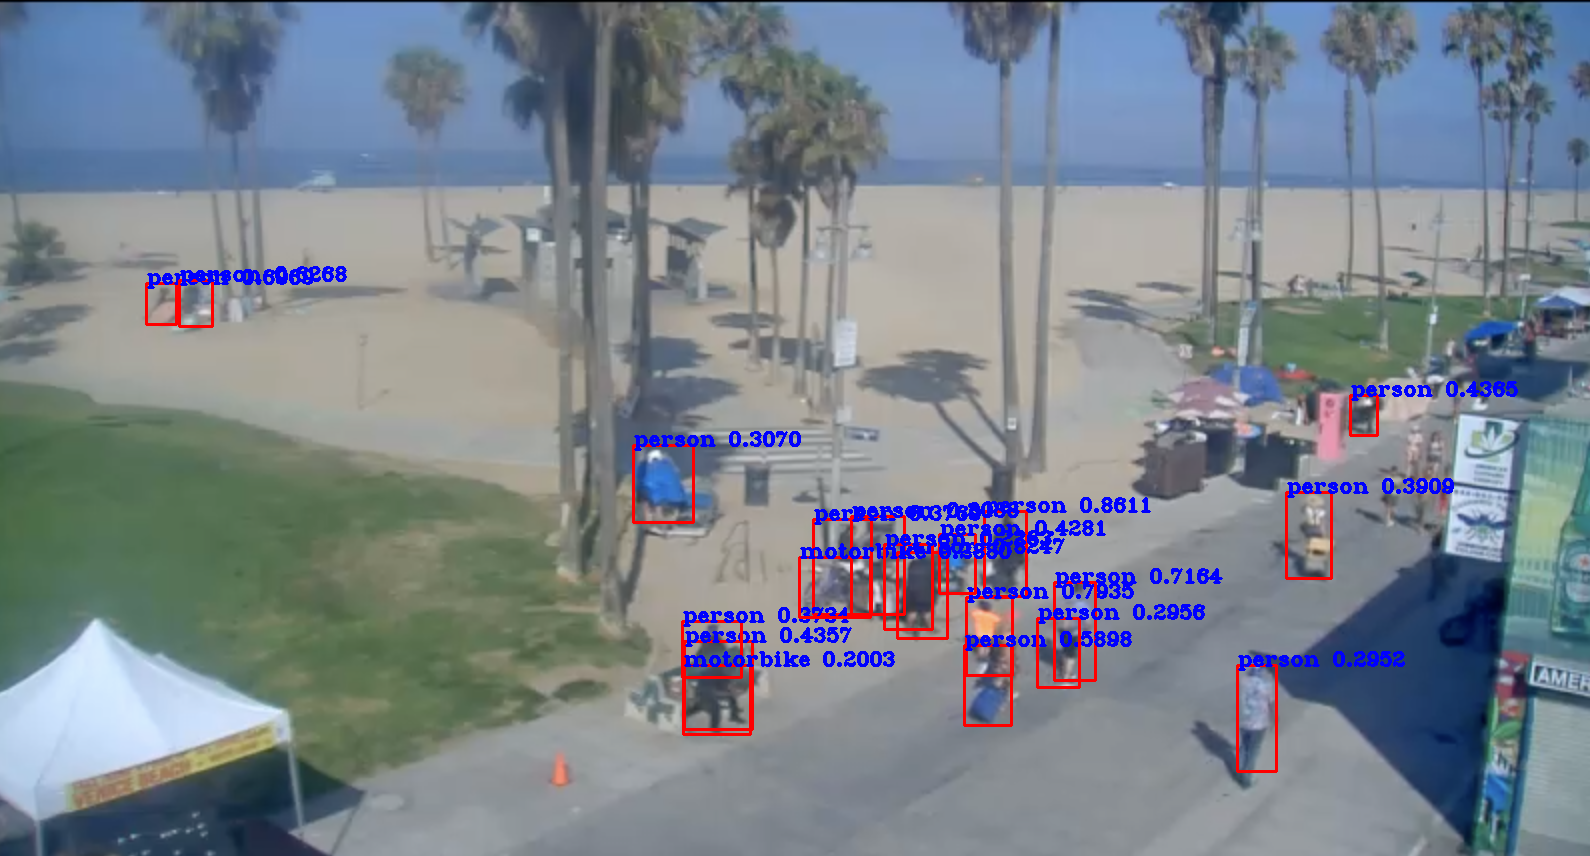

In [31]:
# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image